In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gempy as gp
import pandas as pd

# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Setup

In [2]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [3]:
# meta
geo_model_extent_1 = [0,1000,0,1000,0,1000]
section_1 = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df_1 = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df_1.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df_1.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df_1 = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df_1.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df_1.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df_1.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

# geoData
surface_points_input_data_1 = pd.read_csv('./data/model2_surface_points.csv')
orientaions_input_data_1 = pd.read_csv('./data/model2_orientations.csv')

# Format geological_input_data
surface_points_original_df_1 = surface_points_input_data_1[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df_1.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df_1['param1'] = 10

# Orientaions
orientations_original_df_1 = orientaions_input_data_1[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

# Simulate surface line input

In [4]:
# create a line with noise to simulate client input
x = np.arange(0,5,0.1)
noise = np.random.normal(0,4,50)
z = (x + 3) * ((x - 2) ** 2) * (x - 5) + noise

# rescale values a bit
xvals = x * 200
zvals = z * 10 + 800
zvals[zvals > 1800] = 1800  # cut abouve 2000
zvals[zvals < 0] = 0  # cut abouve 2000
yvals = np.ones((xvals.shape)) * 400

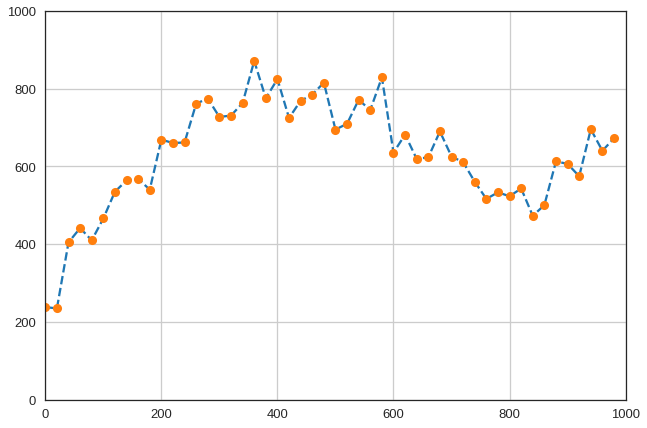

In [5]:
# plot
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(xvals, zvals, '--')
ax1.plot(xvals, zvals, 'o')
ax1.grid()
ax1.set_xlim(0, 1000)
ax1.set_ylim(0, 1000)
plt.show()

# Combine surface input with exisitn surface points

In [6]:
# creat new DataFrame with for new points 
new_points = pd.DataFrame(columns=['X', 'Y', 'Z', 'surface', 'param1'])

# add points
new_points['X'] = xvals
new_points['Y'] = yvals
new_points['Z'] = zvals
new_points['surface'] = 'rock2'
new_points['param1'] = 10

# concate 
new_surface_points_original_df_1 = pd.concat([
    surface_points_original_df_1,
    new_points
], ignore_index=True)

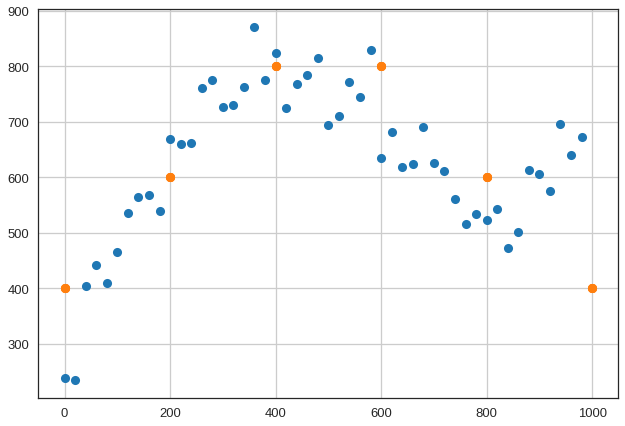

In [7]:
# plot
fig, (ax1) = plt.subplots(1, 1)
# folter rock 1
df = surface_points_original_df_1[surface_points_original_df_1['surface'] == 'rock2']

ax1.plot(new_points['X'], new_points['Z'], 'o')
ax1.plot(df['X'], df['Z'], 'o')
ax1.grid()
plt.show()

In [8]:
# %%timeit
# setup model 1
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=new_surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()


In [9]:
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

Run realizations setup checks until stable workflow.
HOTFIX in gempy/core/gempy_api.py 328


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


In [10]:
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

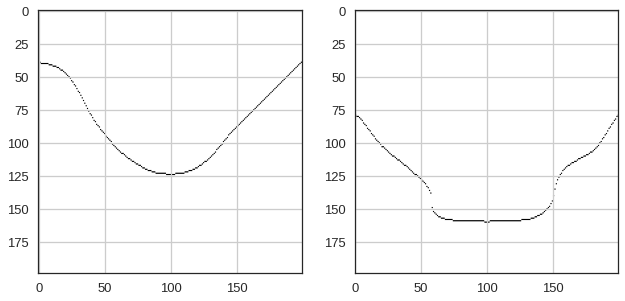

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

In [12]:
extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

In [13]:
tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

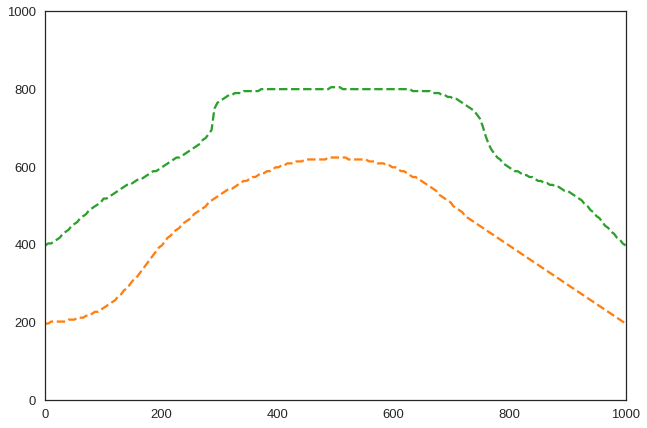

In [14]:
post_pro.plot_tops(tops_dict, 'small_model_tops', 0, 1000, 0, 1000)

In [15]:
# add as surface into geo-model by adding third axis (constant as section parallel to X | Y)


In [16]:
# interpolate surface with nugget effect

In [17]:
# get minimia and maxima  # numerical (+++++-----++++--)

# Notes
If two points of the same surface are at the same (x/y) point with diff z vals it causes the model to give bolognese results.